## Capstone project - Toxic Comments EDAV and Classification
#### --- The 2nd winter [Collaboratory](http://collaboratory.columbia.edu/) **Data Science Bootcamp** for Columbia University PhD students and postdoctoral scholars. 

Google (or *Alphabet*)'s [Jigsaw](https://jigsaw.google.com/) is a unit that aims to use technology to make people's life safer. One area they are working on is *online safety* and to reduce toxicity from online conversations. In Feburary 2017, they released *Conversation AI*, a tool that rates toxicity of online comments, which [didn't work well](https://www.technologyreview.com/s/603735/its-easy-to-slip-toxic-language-past-alphabets-toxic-comment-detector/). As part of their efforts to improve this tool, Jigsaw posted a set of [human-labelled comments](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) on Kaggle.

In this capstone project, you can pursue one of the following directions. 
+ Follow a kaggle kernel on [Exploratory Data Analysis](https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda) and explore a bit futher. 
+ Try to run one of the [models used by *Conversation AI*](https://github.com/conversationai/unintended-ml-bias-analysis).
+ Follow a kaggle kernel on [predictive modeling](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/kernels) and replicate its results. 

The learning goal of this capstone project is to learn how to reproduce another analysis and how to incorporate learning resources found online into your own data science workflow.

In [152]:
# Import modules
# Basic
import pandas as pd
import numpy as np

# Text processing
import nltk, re
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Plot
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [153]:
# Load training data
train = pd.read_csv('../data/train.csv')

In [154]:
# What does the data look like?
train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
1,27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0


In [155]:
# Add a new column indicating whether is non_toxic or not
train['clean'] = train.apply(lambda row: int(row.toxic + row.severe_toxic + row.obscene + row.threat + row.insult + row.identity_hate == 0), axis=1)
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0,0
1,27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0,1
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0,1
3,77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0,1
4,79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0,1


In [156]:
# Process the text
stemmer = PorterStemmer()

def tokenize_and_filter(text):
    # lower
    lowers = text.lower()
    # tokenize
    tokens = [word for sent in nltk.sent_tokenize(lowers) for word in nltk.word_tokenize(sent)]
    # filter out the stopwords
    # tokens = list(filter(lambda word: word not in stopwords.words('english'), tokens))
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(re.sub(r'[^\w\s]','',token))
    cleanText = ' '.join(t for t in filtered_tokens)
    
    return cleanText

cleanTextSeries = []
for row in range(train.shape[0]):
    cleanTextSeries.append(tokenize_and_filter(train.comment_text[row]))

# Append processed comments to original dataframe as a new column
train['comment_processed'] = cleanTextSeries 

In [157]:
# Using source code in profanity module to count profanity words in comments
custom_badwords = pd.read_fwf('../data/bad_words_list.txt',delimiter="\t",header=None)
custom_badwords = custom_badwords[0].tolist()
filtered_badwords = []
for word in custom_badwords:
    if re.search('[a-zA-Z]', word):
        filtered_badwords.append(re.sub(r'[^\w\s]','',word))
#len(custom_badwords)
profanity.load_words(filtered_badwords)

def bad_word_counter(text):
    tokens = [word for word in nltk.word_tokenize(text)]
    counter = 0
    for word in tokens:
        if word in filtered_badwords:
            counter += 1
    return counter

train['bad_word_count'] = train.apply(lambda row: bad_word_counter(row.comment_processed), axis=1)

In [158]:
# For each type of comment, store the corresponding dataframe into a hashtable (dictionary in Python)
type_names = list(train.columns.values)[2:8]
type_names.append('not_toxic')
print(type_names)

df_dict = dict()
for col_idx, name in enumerate(type_names):
    if name != 'not_toxic':
        df_dict[name] = train[train.iloc[:,col_idx+2]==1]
    else:
        df_dict['not_toxic'] = train[(train.toxic==0) & (train.severe_toxic==0) & (train.obscene==0) &(train.threat == 0) &(train.identity_hate == 0) &(train.insult == 0)]

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'not_toxic']


In [159]:
# This is how not_toxic comments look like
df_dict['not_toxic'].head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,comment_processed,bad_word_count
1,27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0,1,please do not vandalize pages as you did with ...,0
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0,1,points of interest i removed the points of int...,0
3,77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0,1,asking some his nationality is a racial offenc...,0
4,79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0,1,the reader here is not going by my say so for ...,0
5,82428052,Fried chickens \n\nIs dat sum fried chickens?,0,0,0,0,0,0,1,fried chickens is dat sum fried chickens,0


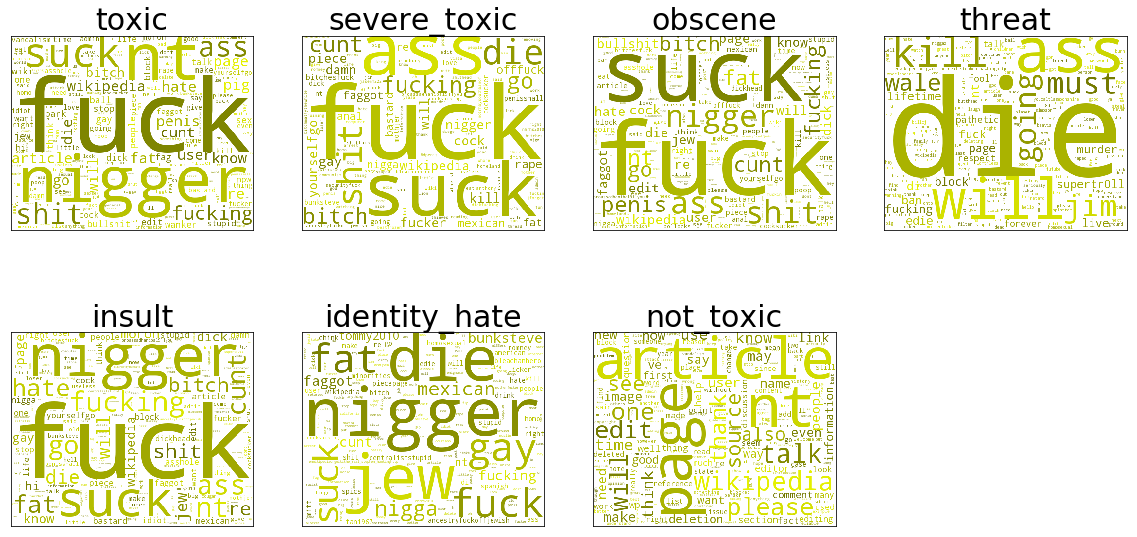

In [160]:
# Visualize each type of comments in wordcloud
def random_color_func(word=None, font_size=None, 
                      position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 45.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    
    return "hsl({}, {}%, {}%)".format(h, s, l)

wc = WordCloud(background_color='white',
               color_func=random_color_func,
               width=500, height=400)

%matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)
f, ax = plt.subplots(2, 4)

for i in range(2):
    for j in range(4):
        if i*4+j < 7:
            wc.generate(" ".join(df_dict[type_names[i*4+j]].comment_processed))
            ax[i,j].imshow(wc)
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            ax[i,j].set_title(type_names[i*4+j],fontdict={'fontsize':30})
        else:
            ax[i,j].set_visible(False)

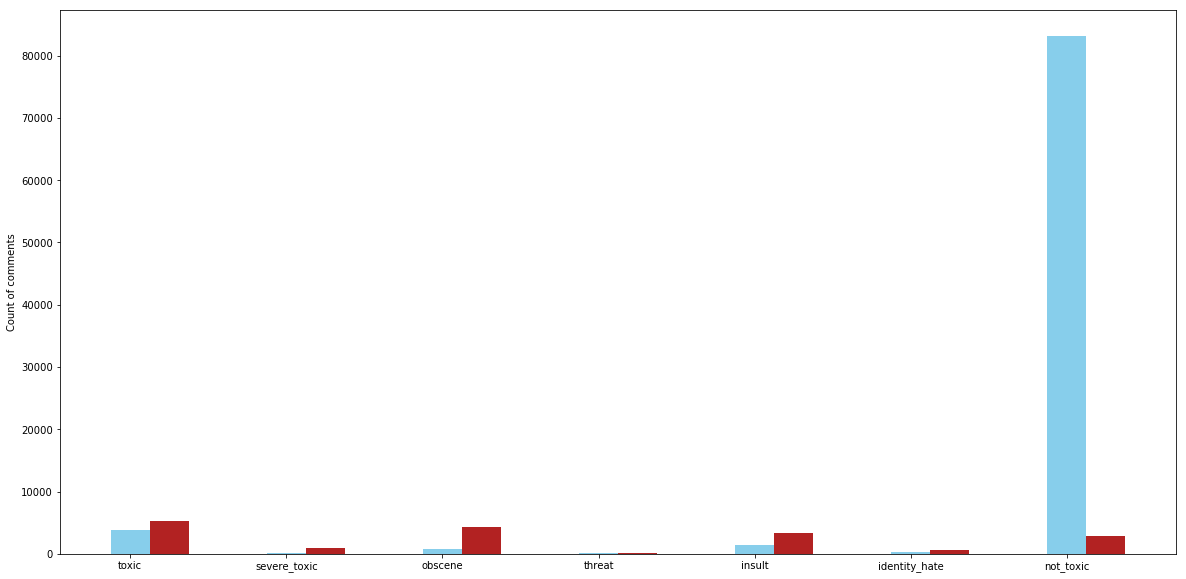

In [161]:
# Side by side bar plot to compare bad_word_count in different types of comments
data = [[0 for i in range(len(type_names))] for j in range(2)]

for idx, name in enumerate(type_names):
    data[0][idx] = (df_dict[name]['bad_word_count'] == 0).sum()
    data[1][idx] = (df_dict[name]['bad_word_count'] != 0).sum()   

X = np.arange(len(type_names))
plt.bar(X + 0.00, data[0], color = 'skyblue', width = 0.25)
plt.bar(X + 0.25, data[1], color = 'firebrick', width = 0.25)
y_labels = type_names
plt.xticks(range(7),y_labels)
plt.ylabel("Count of comments")
plt.show()

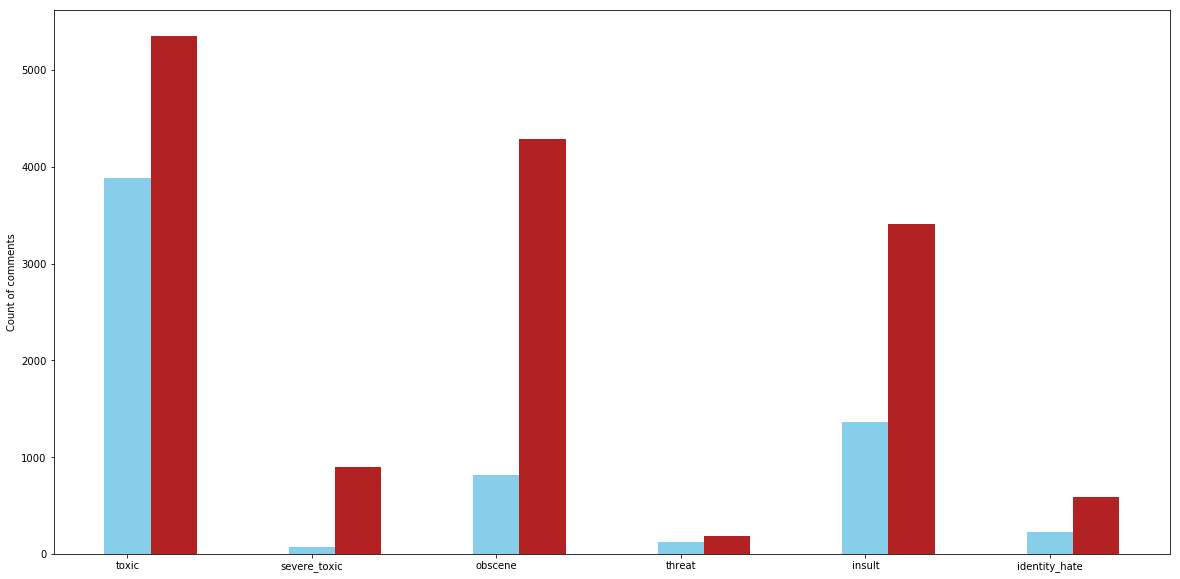

In [162]:
# Zoom out last plot with out non_toxic comments

data = [[0 for i in range(len(type_names)-1)] for j in range(2)]

for idx, name in enumerate(type_names[:6]):
    data[0][idx] = (df_dict[name]['bad_word_count'] == 0).sum()
    data[1][idx] = (df_dict[name]['bad_word_count'] != 0).sum()   


X = np.arange(len(type_names)-1)
plt.bar(X + 0.00, data[0], color = 'skyblue', width = 0.25)
plt.bar(X + 0.25, data[1], color = 'firebrick', width = 0.25)
y_labels = type_names[:6]
plt.xticks(range(6),y_labels)
plt.ylabel("Count of comments")
plt.show()

(0, 800)

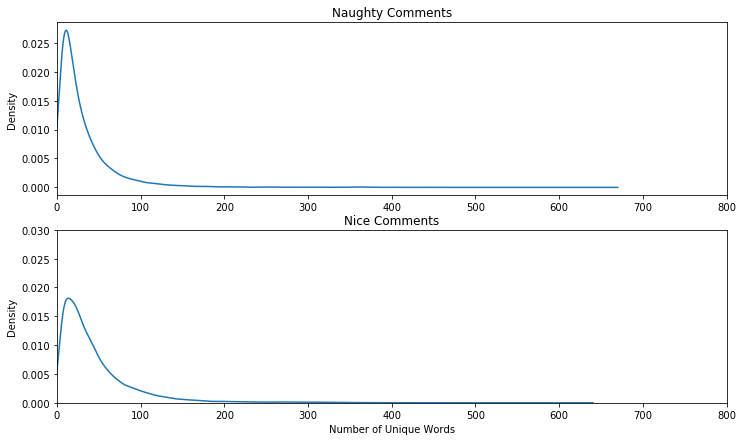

In [165]:
# Count of unique word distribution (contributed by Frankie Pavia)
train['count_unique_word']=train["comment_processed"].apply(lambda x: len(set(str(x).split())))
fig = plt.figure(figsize = (12,7), facecolor='white')
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
train.query('clean==0').count_unique_word.plot(kind='kde', ax=ax1)
train.query('clean==1').count_unique_word.plot(kind='kde', ax=ax2)
ax2.set_ylim(0,0.03)
ax1.set_xlim(0,800)
ax1.set_title('Naughty Comments')
ax2.set_title('Nice Comments')
ax2.set_xlabel('Number of Unique Words')
ax2.set_ylim(0,0.03)
ax2.set_xlim(0,800)

For the prediction part, one [kernel](https://www.kaggle.com/CVxTz/keras-bidirectional-lstm-baseline-lb-0-051/output) on Kaggle uses Keras can give a good baseline for training.